# CNN Image Classification (Fish Dataset)

**Name**: Anom Nur Maulid  
**Class**: TK4601  
**NIM**: 1103223193  

## Objective
Build an end-to-end image classification pipeline using CNN:
- preprocessing & augmentation
- CNN from scratch
- transfer learning
- evaluation & interpretation


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## 1. Check Dataset Structure
We inspect the dataset directory to confirm:
- whether images are already organized by class folders, or
- whether there is an extra nested folder level that we need to point to.


In [ ]:
import os

DATASET_DIR = "/content/drive/MyDrive/UAS ML DL/CNN (ML)/FishImgDataset"

print("DATASET_DIR exists?", os.path.exists(DATASET_DIR))
if os.path.exists(DATASET_DIR):
    items = sorted(os.listdir(DATASET_DIR))
    print("\nTop-level items (first 50):")
    for f in items[:50]:
        print("-", f)
    if len(items) > 50:
        print("... (more than 50 items)")

    # list subfolders (candidate class dirs)
    subdirs = [d for d in items if os.path.isdir(os.path.join(DATASET_DIR, d))]
    print("\nSubfolders (first 30):")
    for d in subdirs[:30]:
        print("-", d)

    # if there is exactly one subfolder, show inside it (common nested structure)
    if len(subdirs) == 1:
        inner = os.path.join(DATASET_DIR, subdirs[0])
        inner_items = sorted(os.listdir(inner))
        print("\nDetected single nested folder. Contents inside it (first 50):")
        for f in inner_items[:50]:
            print("-", f)
        if len(inner_items) > 50:
            print("... (more than 50 items)")


DATASET_DIR exists? True

Top-level items (first 50):
- test
- train
- val

Subfolders (first 30):
- test
- train
- val


## 2. Verify Class Folders and Image Counts
We verify:
- number of classes in train/val/test
- class names are consistent across splits
- image counts per class (to detect class imbalance)


In [ ]:
import os

BASE_DIR = "/content/drive/MyDrive/UAS ML DL/CNN (ML)/FishImgDataset"
train_dir = os.path.join(BASE_DIR, "train")
val_dir   = os.path.join(BASE_DIR, "val")
test_dir  = os.path.join(BASE_DIR, "test")

IMG_EXT = (".jpg", ".jpeg", ".png", ".bmp", ".webp")

def class_folders(split_dir):
    return sorted([d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))])

def count_images(split_dir, classes):
    counts = {}
    for cls in classes:
        cls_path = os.path.join(split_dir, cls)
        files = []
        for root, _, fs in os.walk(cls_path):
            files.extend([f for f in fs if f.lower().endswith(IMG_EXT)])
        counts[cls] = len(files)
    return counts

train_classes = class_folders(train_dir)
val_classes   = class_folders(val_dir)
test_classes  = class_folders(test_dir)

print("Num classes")
print("train:", len(train_classes))
print("val  :", len(val_classes))
print("test :", len(test_classes))

print("\nFirst 20 class names (train):")
print(train_classes[:20])

print("\nClass sets identical?")
print("train == val :", set(train_classes) == set(val_classes))
print("train == test:", set(train_classes) == set(test_classes))

# hitung jumlah gambar per kelas
train_counts = count_images(train_dir, train_classes)
val_counts   = count_images(val_dir, val_classes)
test_counts  = count_images(test_dir, test_classes)

def summary(name, counts):
    total = sum(counts.values())
    min_cls = min(counts, key=counts.get)
    max_cls = max(counts, key=counts.get)
    print(f"\n{name} total images:", total)
    print(f"{name} min class: {min_cls} ({counts[min_cls]})")
    print(f"{name} max class: {max_cls} ({counts[max_cls]})")

summary("train", train_counts)
summary("val", val_counts)
summary("test", test_counts)

sorted_train = sorted(train_counts.items(), key=lambda x: x[1])
print("\nTrain smallest 5:", sorted_train[:5])
print("Train largest 5 :", sorted_train[-5:])


Num classes
train: 31
val  : 31
test : 31

First 20 class names (train):
['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 'Mosquito Fish']

Class sets identical?
train == val : True
train == test: True

train total images: 8814
train min class: Green Spotted Puffer (110)
train max class: Grass Carp (1222)

val total images: 2751
val min class: Green Spotted Puffer (34)
val max class: Grass Carp (378)

test total images: 1760
test min class: Green Spotted Puffer (22)
test max class: Grass Carp (238)

Train smallest 5: [('Green Spotted Puffer', 110), ('Climbing Perch', 152), ('Scat Fish', 154), ('Bangus', 171), ('Mullet', 174)]
Train largest 5 : [('Knifefish', 319), ('Silver Barb', 339), ('Glass Perchlet', 397), ('Goby', 60

## 3. Build TensorFlow Datasets (train/val/test)
We load images from directories using `tf.keras.utils.image_dataset_from_directory`.
We enforce the same `class_names` order across train/val/test to keep labels consistent.
We also prepare performance optimizations (cache/prefetch).


In [ ]:
import os
import tensorflow as tf
import numpy as np

# Paths
BASE_DIR = "/content/drive/MyDrive/UAS ML DL/CNN (ML)/FishImgDataset"
train_dir = os.path.join(BASE_DIR, "train")
val_dir   = os.path.join(BASE_DIR, "val")
test_dir  = os.path.join(BASE_DIR, "test")

# Reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Settings
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Class names (fix ordering to avoid label mismatch)
class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
NUM_CLASSES = len(class_names)

print("NUM_CLASSES:", NUM_CLASSES)
print("First 10 classes:", class_names[:10])

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    class_names=class_names,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="int",
    class_names=class_names,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    class_names=class_names,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Normalize to [0,1]
def normalize_img(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    return x, y

train_ds = train_ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
val_ds   = val_ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
test_ds  = test_ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

# Performance
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.cache().prefetch(tf.data.AUTOTUNE)

# Quick sanity check: one batch
for images, labels in train_ds.take(1):
    print("Batch images shape:", images.shape)
    print("Batch labels shape:", labels.shape)
    print("Label min/max:", int(tf.reduce_min(labels)), int(tf.reduce_max(labels)))


NUM_CLASSES: 31
First 10 classes: ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish']
Found 8830 files belonging to 31 classes.
Found 2751 files belonging to 31 classes.
Found 1761 files belonging to 31 classes.
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Label min/max: 1 29


## 4. Visualize Sample Images + Check Label Range
We visualize a small batch of images with their class names.
We also verify that label indices span all classes (0..NUM_CLASSES-1).


Unique labels seen in first 20 batches: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Min label: 0 Max label: 30
Expected min/max: 0 30


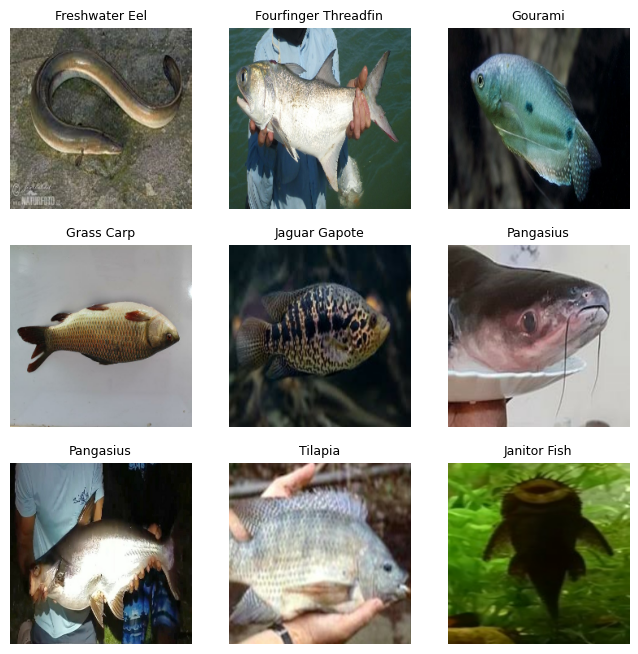

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# 1) cek label range dari beberapa batch train
label_set = set()
for _, y in train_ds.take(20):  # cek 20 batch pertama
    label_set.update(y.numpy().tolist())

label_set = sorted(label_set)
print("Unique labels seen in first 20 batches:", label_set)
print("Min label:", min(label_set), "Max label:", max(label_set))
print("Expected min/max:", 0, NUM_CLASSES-1)

# 2) tampilkan 9 gambar
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    images = images.numpy()
    labels = labels.numpy()
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[int(labels[i])], fontsize=9)
        plt.axis("off")
plt.show()


## 5. Handle Class Imbalance (Class Weights)
Because some classes have much fewer images than others, we compute `class_weight`
so the model pays more attention to minority classes during training.


In [ ]:
import os
import numpy as np

BASE_DIR = "/content/drive/MyDrive/UAS ML DL/CNN (ML)/FishImgDataset"
train_dir = os.path.join(BASE_DIR, "train")

IMG_EXT = (".jpg", ".jpeg", ".png", ".bmp", ".webp")

# hitung jumlah gambar per kelas berdasarkan folder train
train_counts = {}
for cls in class_names:
    cls_path = os.path.join(train_dir, cls)
    n = 0
    for root, _, files in os.walk(cls_path):
        n += sum(1 for f in files if f.lower().endswith(IMG_EXT))
    train_counts[cls] = n

total = sum(train_counts.values())
num_classes = len(class_names)

# class weight: total/(num_classes*count)
class_weight = {
    i: (total / (num_classes * max(train_counts[cls], 1)))
    for i, cls in enumerate(class_names)
}

print("Total train images:", total)
print("Min class:", min(train_counts, key=train_counts.get), train_counts[min(train_counts, key=train_counts.get)])
print("Max class:", max(train_counts, key=train_counts.get), train_counts[max(train_counts, key=train_counts.get)])

# tampilkan beberapa contoh weight
sorted_w = sorted(class_weight.items(), key=lambda x: x[1], reverse=True)
print("\nTop 5 highest weights (minority classes):")
for i, w in sorted_w[:5]:
    print(i, class_names[i], "->", round(w, 3))

print("\nTop 5 lowest weights (majority classes):")
for i, w in sorted_w[-5:]:
    print(i, class_names[i], "->", round(w, 3))


Total train images: 8814
Min class: Green Spotted Puffer 110
Max class: Grass Carp 1222

Top 5 highest weights (minority classes):
12 Green Spotted Puffer -> 2.585
4 Climbing Perch -> 1.871
24 Scat Fish -> 1.846
0 Bangus -> 1.663
21 Mullet -> 1.634

Top 5 lowest weights (majority classes):
17 Knifefish -> 0.891
25 Silver Barb -> 0.839
7 Glass Perchlet -> 0.716
8 Goby -> 0.468
11 Grass Carp -> 0.233


## 6. CNN From Scratch (with Augmentation)
We build a simple CNN architecture from scratch and apply data augmentation to improve generalization.
We train with:
- EarlyStopping (avoid overfitting)
- ModelCheckpoint (save best model)
- class_weight (handle imbalance)
Then we evaluate on validation set.


In [ ]:
import tensorflow as tf

# Augmentation layer (only applied during training)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
])

# CNN from scratch
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    data_augmentation,

    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax"),
])

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

cnn_model.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="/content/drive/MyDrive/UAS ML DL/CNN (ML)/cnn_scratch_best.keras",
        monitor="val_accuracy",
        save_best_only=True
    )
]

history_cnn = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

val_loss, val_acc = cnn_model.evaluate(val_ds, verbose=0)
print("CNN Scratch | val_loss:", val_loss, "| val_acc:", val_acc)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │         7,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,241,695 (50.51 MB)

 Trainable params: 13,241,695 (50.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - accuracy: 0.0460 - loss: 3.4048 - val_accuracy: 0.1934 - val_loss: 2.8865
Epoch 2/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.1595 - loss: 2.9570 - val_accuracy: 0.2879 - val_loss: 2.5078
Epoch 3/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.2517 - loss: 2.6026 - val_accuracy: 0.3842 - val_loss: 2.2001
Epoch 4/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - accuracy: 0.3218 - loss: 2.3372 - val_accuracy: 0.4602 - val_loss: 1.8666
Epoch 5/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - accuracy: 0.3749 - loss: 2.1516 - val_accuracy: 0.4758 - val_loss: 1.8214
Epoch 6/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.4242 - loss: 1.9892 - val_accuracy: 0.5213 - val_loss: 1.6280
Epoch 7/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.4457 - loss: 1.8908 - val_accuracy: 0.5573 - val_loss: 1.5475
Epoch 8/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - accuracy: 0.4829 - loss: 1.7851 - v

## 7. Evaluation (Confusion Matrix, Classification Report) + Learning Curves
We evaluate the CNN model on validation set:
- confusion matrix
- classification report (precision/recall/f1 per class)

We also plot training vs validation curves (accuracy and loss).


Validation samples: 2751

Confusion Matrix shape: (31, 31)

Confusion Matrix (first 5 rows):
[[31  1  0  0  0]
 [ 1 39  0  4  1]
 [ 0  0 55  0  2]
 [ 0  2  0 77  1]
 [ 0  0  0  0 29]]

=== Classification Report (Validation) ===
                       precision    recall  f1-score   support

               Bangus     0.6458    0.5962    0.6200        52
        Big Head Carp     0.5909    0.6190    0.6047        63
   Black Spotted Barb     0.7971    0.8730    0.8333        63
              Catfish     0.4936    0.7938    0.6087        97
       Climbing Perch     0.3494    0.6042    0.4427        48
 Fourfinger Threadfin     0.8000    0.8667    0.8320        60
       Freshwater Eel     0.7077    0.5476    0.6174        84
       Glass Perchlet     0.8947    0.5484    0.6800       124
                 Goby     0.7630    0.5450    0.6358       189
            Gold Fish     1.0000    1.0000    1.0000        65
              Gourami     0.8876    0.8144    0.8495        97
           Gras

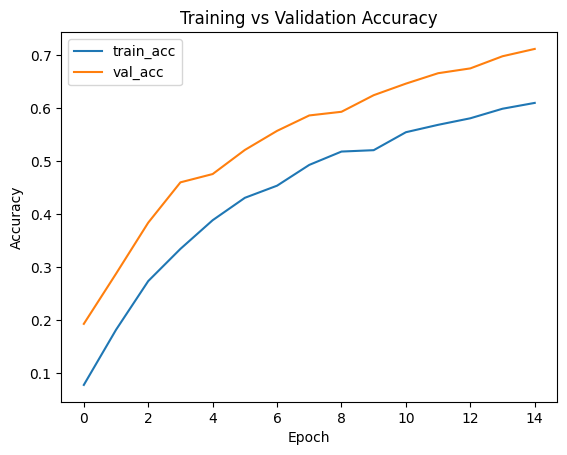

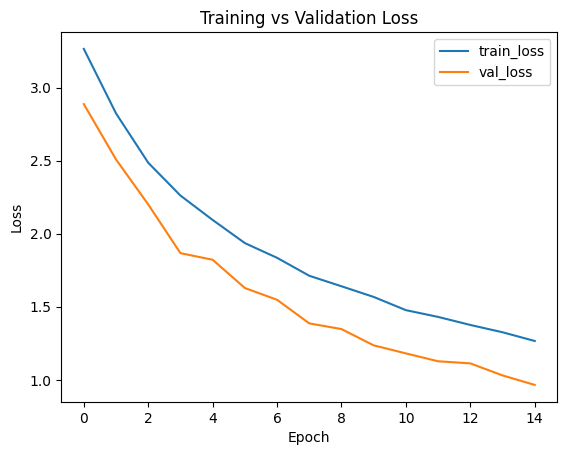

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# 1) collect y_true and y_pred on validation
y_true = []
y_pred = []

for x_batch, y_batch in val_ds:
    probs = cnn_model.predict(x_batch, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(y_batch.numpy().tolist())
    y_pred.extend(preds.tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Validation samples:", len(y_true))

# 2) confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix shape:", cm.shape)

# tampilkan confusion matrix ringkas (tanpa heatmap biar ringan)
print("\nConfusion Matrix (first 5 rows):")
print(cm[:5, :5])

# 3) classification report
report = classification_report(
    y_true, y_pred,
    target_names=class_names,
    digits=4,
    zero_division=0
)
print("\n=== Classification Report (Validation) ===")
print(report)

# 4) learning curves
acc = history_cnn.history.get("accuracy", [])
val_acc = history_cnn.history.get("val_accuracy", [])
loss = history_cnn.history.get("loss", [])
val_loss = history_cnn.history.get("val_loss", [])

plt.figure()
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


## 8. Transfer Learning (MobileNetV2) - Fixed KerasTensor Issue
We rebuild the model using Keras layers only (Rescaling + Lambda preprocess_input),
so it works in the Functional API without KerasTensor errors.


In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
NUM_CLASSES = len(class_names)

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# data_augmentation output sudah float tensor, jadi aman lanjut pakai layer Keras
x = data_augmentation(inputs)

# sebelumnya dataset kita sudah 0..1, MobileNetV2 butuh -1..1
# preprocess_input mengasumsikan input 0..255, jadi:
x = tf.keras.layers.Rescaling(255.0)(x)  # 0..255
x = tf.keras.layers.Lambda(preprocess_input)(x)  # -> -1..1

x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

tl_model = tf.keras.Model(inputs, outputs)

tl_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

tl_model.summary()

callbacks_tl = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="/content/drive/MyDrive/UAS ML DL/CNN (ML)/mobilenetv2_feature_extractor_best.keras",
        monitor="val_accuracy",
        save_best_only=True
    )
]

history_tl = tl_model.fit(
    train_ds,                 # pakai train_ds normal (0..1), karena model sudah handle preprocess
    validation_data=val_ds,   # sama
    epochs=10,
    class_weight=class_weight,
    callbacks=callbacks_tl,
    verbose=1
)

val_loss_tl, val_acc_tl = tl_model.evaluate(val_ds, verbose=0)
print("MobileNetV2 (Frozen) | val_loss:", val_loss_tl, "| val_acc:", val_acc_tl)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 31)             │        39,711 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,297,695 (8.77 MB)

 Trainable params: 39,711 (155.12 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 26s 78ms/step - accuracy: 0.3724 - loss: 2.4424 - val_accuracy: 0.7674 - val_loss: 0.8972
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - accuracy: 0.7548 - loss: 0.8823 - val_accuracy: 0.8132 - val_loss: 0.6775
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - accuracy: 0.8074 - loss: 0.6828 - val_accuracy: 0.8495 - val_loss: 0.5658
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.8350 - loss: 0.5754 - val_accuracy: 0.8561 - val_loss: 0.5187
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - accuracy: 0.8408 - loss: 0.5235 - val_accuracy: 0.8593 - val_loss: 0.4849
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - accuracy: 0.8473 - loss: 0.4989 - val_accuracy: 0.8691 - val_loss: 0.4512
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - accuracy: 0.8666 - loss: 0.4458 - val_accuracy: 0.8822 - val_loss: 0.4086
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.8595 - loss: 0.4233 - 

## 9. Fine-Tuning MobileNetV2 (Unfreeze Last Layers)
We load the best frozen MobileNetV2 model (if needed), then unfreeze the last layers
and continue training with a smaller learning rate.


In [12]:
import os
import tensorflow as tf

# path model terbaik dari tahap "Frozen"
FEATURE_CKPT = "/content/drive/MyDrive/UAS ML DL/CNN (ML)/mobilenetv2_feature_extractor_best.keras"

# 1) pastikan tl_model ada (kalau runtime restart, load dari file)
if "tl_model" not in globals():
    if not os.path.exists(FEATURE_CKPT):
        raise FileNotFoundError("Checkpoint frozen tidak ditemukan: " + FEATURE_CKPT)
    tl_model = tf.keras.models.load_model(FEATURE_CKPT)
    print("Loaded frozen model from:", FEATURE_CKPT)

# 2) cari layer base MobileNetV2 di dalam tl_model
base_model = None
for layer in tl_model.layers:
    if isinstance(layer, tf.keras.Model) and "mobilenetv2" in layer.name.lower():
        base_model = layer
        break

if base_model is None:
    raise ValueError("Tidak menemukan MobileNetV2 base model di dalam tl_model.")

print("Base model name:", base_model.name)
print("Before fine-tune | base_model.trainable:", base_model.trainable)

# 3) unfreeze sebagian layer terakhir
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 40  # buka 40 layer terakhir

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print("After fine-tune  | base_model.trainable:", base_model.trainable)
print("Fine-tune from layer:", fine_tune_at, "out of", len(base_model.layers))

# 4) compile ulang dengan LR kecil
tl_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks_ft = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="/content/drive/MyDrive/UAS ML DL/CNN (ML)/mobilenetv2_finetuned_best.keras",
        monitor="val_accuracy",
        save_best_only=True
    )
]

history_ft = tl_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weight,
    callbacks=callbacks_ft,
    verbose=1
)

val_loss_ft, val_acc_ft = tl_model.evaluate(val_ds, verbose=0)
print("MobileNetV2 (Fine-tuned) | val_loss:", val_loss_ft, "| val_acc:", val_acc_ft)


Base model name: mobilenetv2_1.00_224
Before fine-tune | base_model.trainable: False
After fine-tune  | base_model.trainable: True
Fine-tune from layer: 114 out of 154
Epoch 1/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 38s 101ms/step - accuracy: 0.6697 - loss: 1.1410 - val_accuracy: 0.8957 - val_loss: 0.3454
Epoch 2/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.8136 - loss: 0.5865 - val_accuracy: 0.9026 - val_loss: 0.3318
Epoch 3/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 24s 88ms/step - accuracy: 0.8506 - loss: 0.4654 - val_accuracy: 0.8975 - val_loss: 0.3218
Epoch 4/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 25s 92ms/step - accuracy: 0.8703 - loss: 0.4028 - val_accuracy: 0.9073 - val_loss: 0.3004
Epoch 5/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.8815 - loss: 0.3576 - val_accuracy: 0.9149 - val_loss: 0.2832
MobileNetV2 (Fine-tuned) | val_loss: 0.2831932604312897 | val_acc: 0.9149399995803833


## 10. Final Comparison (Scratch vs Transfer Learning) + F1 Scores
We compare the final models using:
- Validation Accuracy
- Macro F1-score (treat all classes equally)
- Weighted F1-score (accounts for class frequency)

This will be used in the final report section.


In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

def eval_model_on_val(model, val_ds, class_names, label="model"):
    y_true, y_pred = [], []
    for xb, yb in val_ds:
        probs = model.predict(xb, verbose=0)
        preds = np.argmax(probs, axis=1)
        y_true.extend(yb.numpy().tolist())
        y_pred.extend(preds.tolist())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    acc = accuracy_score(y_true, y_pred)
    rep = classification_report(
        y_true, y_pred, target_names=class_names, digits=4, zero_division=0, output_dict=True
    )
    macro_f1 = rep["macro avg"]["f1-score"]
    weighted_f1 = rep["weighted avg"]["f1-score"]
    return acc, macro_f1, weighted_f1

# 1) ambil skor dari CNN scratch (kalau object-nya masih ada)
# kalau cnn_model tidak ada karena restart, kamu bisa skip baris scratch atau load dari checkpoint scratch
scratch_acc = 0.7117412090301514  # dari output kamu
scratch_macro_f1 = 0.7035         # dari report kamu
scratch_weighted_f1 = 0.7159      # dari report kamu

# 2) evaluasi TL model (fine-tuned) langsung
ft_acc, ft_macro_f1, ft_weighted_f1 = eval_model_on_val(tl_model, val_ds, class_names, "mobilenet_finetuned")

# frozen acc dari output kamu (pakai value yang sudah kamu dapat)
frozen_acc = 0.8920392394065857

results = pd.DataFrame([
    {"model": "CNN_Scratch", "val_acc": scratch_acc, "macro_f1": scratch_macro_f1, "weighted_f1": scratch_weighted_f1},
    {"model": "MobileNetV2_Frozen", "val_acc": frozen_acc, "macro_f1": np.nan, "weighted_f1": np.nan},
    {"model": "MobileNetV2_FineTuned", "val_acc": ft_acc, "macro_f1": ft_macro_f1, "weighted_f1": ft_weighted_f1},
]).sort_values("val_acc", ascending=False)

print(results)

# simpan hasil untuk laporan
out_path = "/content/drive/MyDrive/UAS ML DL/CNN (ML)/cnn_model_comparison.csv"
results.to_csv(out_path, index=False)
print("Saved:", out_path)


                   model   val_acc  macro_f1  weighted_f1
2  MobileNetV2_FineTuned  0.914940  0.915639     0.917244
1     MobileNetV2_Frozen  0.892039       NaN          NaN
0            CNN_Scratch  0.711741  0.703500     0.715900
Saved: /content/drive/MyDrive/UAS ML DL/CNN (ML)/cnn_model_comparison.csv


## Conclusion & Interpretation (CNN)
- The dataset contains **31 fish classes** with **class imbalance** (e.g., the largest class has far more images than the smallest), so we used **data augmentation** and **class weights**.
- **CNN from scratch** achieved **val_acc ≈ 0.712** (macro F1 ≈ 0.704), showing the model can learn useful features but still limited by data size/imbalance.
- **Transfer learning with MobileNetV2** significantly improved performance:
  - Frozen feature extractor: **val_acc ≈ 0.892**
  - Fine-tuned MobileNetV2: **val_acc ≈ 0.915**, **macro F1 ≈ 0.916**, **weighted F1 ≈ 0.917**
- Overall, the best model for this task is **MobileNetV2 fine-tuned**, which benefits from ImageNet pretraining and slight fine-tuning on the fish dataset.


## Optional: Evaluate Best Model on Test Set
We evaluate the fine-tuned MobileNetV2 model on the test split to estimate generalization performance.


In [14]:
test_loss, test_acc = tl_model.evaluate(test_ds, verbose=0)
print("MobileNetV2 (Fine-tuned) | test_loss:", test_loss, "| test_acc:", test_acc)


MobileNetV2 (Fine-tuned) | test_loss: 0.278521865606308 | test_acc: 0.9187961220741272


## Final Results (Summary)
**Best Model:** MobileNetV2 (Fine-tuned)

**Validation:**
- Accuracy: ~0.9149
- Macro F1: ~0.9156
- Weighted F1: ~0.9172

**Test:**
- Accuracy: ~0.9188

Transfer learning + fine-tuning achieved the best performance compared to CNN from scratch.
